# Integration and label transfer with Tabula Muris

Following the general tutorial on atlas-level integration, here we show using scVI and scANVI for label transfer. In this setting we have:

1. Fully-labeled reference dataset
1. Unlabeled query dataset

We will demonstrate this functionality using Tabula Muris:

- Tabula Muris Consortium. "Single-cell transcriptomics of 20 mouse organs creates a Tabula Muris." Nature 562.7727 (2018): 367-372.

It is important to note that this tutorial covers *de novo* integration. With scvi-tools you can also perform online or sequential integration (i.e., *reference mapping*). Please see the scArches tutorial for more details.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [1]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSRD

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.2.1


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

We supply Scanpy's read function with a backup url, which covers automatic data download.

In [4]:
tm_droplet_path = os.path.join(save_dir.name, "TM_droplet.h5ad")
tm_facs_path = os.path.join(save_dir.name, "TM_facs.h5ad")

tm_droplet = sc.read(
    tm_droplet_path,
    backup_url="https://figshare.com/ndownloader/files/23938934",
)
tm_facs = sc.read(
    tm_facs_path,
    backup_url="https://figshare.com/ndownloader/files/23939711",
)

  0%|          | 0.00/3.78G [00:00<?, ?B/s]

  0%|          | 0.00/2.20G [00:00<?, ?B/s]

We subset to labelled bone marrow cells from female mice because it is a reasonably sized dataset that will allow us to validate our method's ability to transfer labels from one dataset to another. In Tabula Muris, we are provided data collected using 10x Chromium, as well as SmartSeq2 data.

In [5]:
tm_droplet = tm_droplet[
    (tm_droplet.obs.tissue == "Marrow")
    & (~tm_droplet.obs.cell_ontology_class.isna())
    & (tm_droplet.obs.sex == "female")
].copy()
tm_facs = tm_facs[
    (tm_facs.obs.tissue == "Marrow")
    & (~tm_facs.obs.cell_ontology_class.isna())
    & (tm_facs.obs.sex == "female")
].copy()

tm_droplet.obs["tech"] = "10x"
tm_facs.obs["tech"] = "SS2"

In [6]:
tm_droplet.shape, tm_facs.shape

((11707, 20138), (4200, 22966))

## Dataset preprocessing

### Normalize Smartseq2 matrix by gene length

We apply gene-length normalization because the number of reads representing a transcript is proportional to the lenght of the transcript, unless UMIs are used (as in 10x). A discussion of this phenomenon can be found in this 2017 [paper](https://europepmc.org/article/med/28529717) by Phipson B.
Other than the gene length normalization, no other normalization is needed. scVI or scANVI is designed to handle sequencing depth and does not need cell-wise normalization. Normalizing and scaling the data will be detrimental to the performance of scVI and scANVI since they model explicitly the count data.

The gene length file here is computed by taking the average length of alal transcripts corresponding to a mouse gene recorded in the ensembl dataabase.

```{note}
For general pre-processing for various datatypes used by scvi-tools models, see the [preprocessing tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/use_cases/preprocessing).
```

In [7]:
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)
gene_len.head()

,1
0,
0610007C21Rik,94.571429
0610007L01Rik,156.000000
0610007P08Rik,202.272727
0610007P14Rik,104.000000
0610007P22Rik,158.750000


In [8]:
gene_len = gene_len.reindex(tm_facs.var.index).dropna()
tm_facs = tm_facs[:, gene_len.index]
assert (tm_facs.var.index == gene_len.index).sum() == tm_facs.shape[1]
tm_facs.X = tm_facs.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
tm_facs.X = np.rint(tm_facs.X)

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


### Dataset concatenation and gene selection

Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate for large gene sets in terms of runtime, we usually recommend filtering genes for best performance when the dataset has few number of cells. As a rule of thumb, performance starts to decrease when number of cells and number of genes are comparable. This point is emphasized in this [comparative analysis](https://doi.org/10.1101/2020.05.22.111161) of data integration algorithms for scRNA-seq data.

We perform this gene selection using the Scanpy pipeline while keeping the raw data in the `adata.raw` object. We obtain variable genes from each dataset and take their intersections via the Scanpy function.

In [9]:
adata = anndata.concat([tm_droplet, tm_facs])
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="tech",
    subset=True,
)

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

- Register the AnnData object with the correct key to identify the sample.
- Create an SCVI model object.

In [10]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech")

In [11]:
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

Now we train scVI. This should take a couple of minutes on a Colab session

In [12]:
scvi_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


`Trainer.fit` stopped: `max_epochs=400` reached.


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [13]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

Finally, we visualize the learned scVI embeddings.

In [18]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

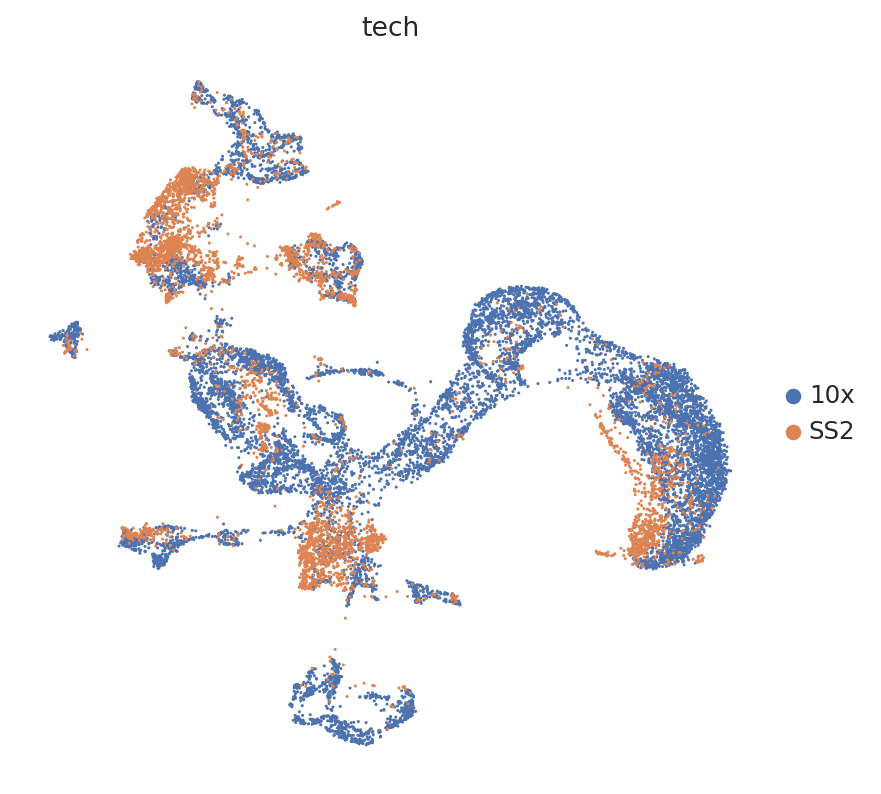

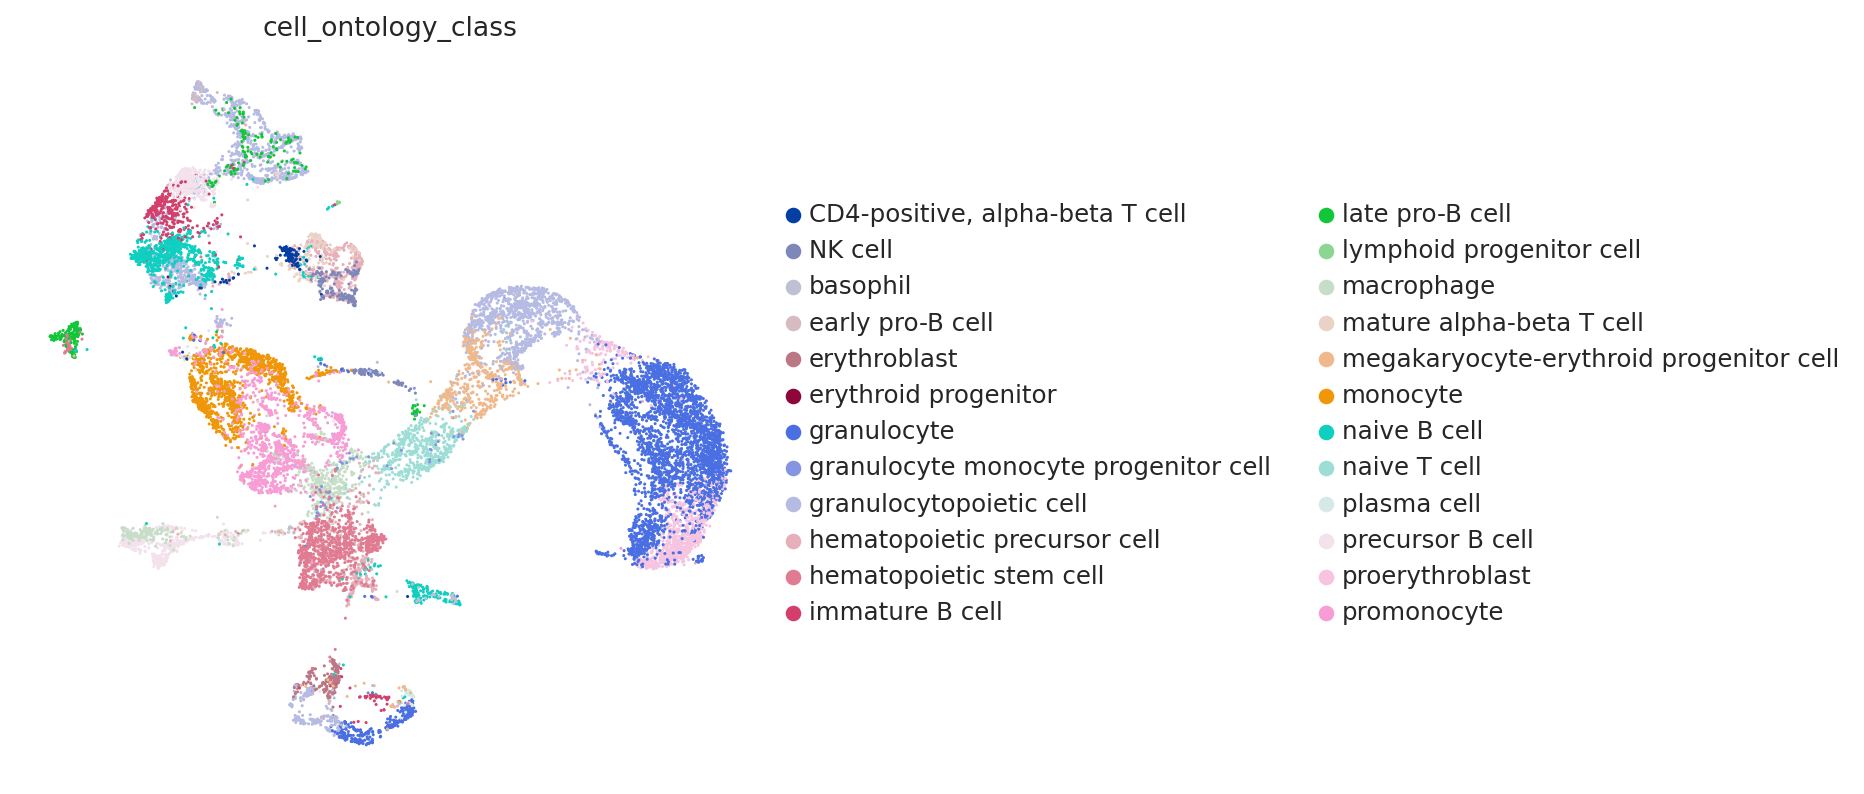

In [21]:
sc.pl.umap(
    adata,
    color=["tech"],
    frameon=False,
    ncols=1,
)
sc.pl.umap(
    adata,
    color=["cell_ontology_class"],
    frameon=False,
    ncols=1,
)

Because this combination of datasets is used for benchmarking purposes, we have access here to curated annotations. We can use those to assess whether the harmonization worked reasonably well.

From a quick glance, it looks like the integration worked well. Indeed, the two datasets are relatively mixed in latent space and the cell types cluster together. A more refined analysis may be done at the level of markers.

## Transfer of annotations with scANVI

With scVI alone, we can train a classifier (e.g., [`RandomForestClassifer`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) on the latent representation of the labeled data and then obtain predictions for the query data. For example, we can imagine the 10x data is unannotated and then proceed to transfer labels using the latent reprsentation of the SS2 data.

We can also try to obtain a better latent representation/predictions by using the labels to inform the latent space. This is where scANVI comes in. scANVI uses semi-supervised learning to improve the model learned with scVI, allowing us to transfer our cell type knowledge from the reference to the query data. For this, we simply need to indicate to scANVI:

- the sample identifier for each cell (as in scVI), which in this case is the technology (10x vs SS2)
- the cell type, or an unnassigned label for each cell

#### scANVI labels

We assume that the SS2 data is annotated and the 10X data is not. Only the labels of the cells from the labelled SS2 dataset will be kept in the `adata.obs` column `'celltype_scanvi'`. All the 10X cells will have `'celltype_scanvi'` of value 'Unknown'.

In [22]:
SCANVI_CELLTYPE_KEY = "celltype_scanvi"

adata.obs[SCANVI_CELLTYPE_KEY] = "Unknown"
ss2_mask = adata.obs["tech"] == "SS2"
adata.obs[SCANVI_CELLTYPE_KEY][ss2_mask] = adata.obs.cell_ontology_class[ss2_mask].values

/tmp/ipykernel_3464019/2754080985.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[SCANVI_CELLTYPE_KEY][ss2_mask] = adata.obs.cell_ontology_class[ss2_mask].values
/tmp/ipykernel_3464019/2754080985.py:5: SettingWithCopyWarning: 


In [23]:
np.unique(adata.obs[SCANVI_CELLTYPE_KEY], return_counts=True)

(array(['CD4-positive, alpha-beta T cell', 'NK cell', 'Unknown',
        'basophil', 'early pro-B cell', 'granulocyte',
        'granulocyte monocyte progenitor cell', 'granulocytopoietic cell',
        'hematopoietic stem cell', 'immature B cell', 'late pro-B cell',
        'lymphoid progenitor cell', 'macrophage',
        'mature alpha-beta T cell',
        'megakaryocyte-erythroid progenitor cell', 'naive B cell',
        'precursor B cell', 'promonocyte'], dtype=object),
 array([  107,   139, 11707,    26,    24,   773,    52,    67,   894,
          281,   132,    13,   136,   150,    22,   740,   321,   323]))

Since we've already trained an scVI model on our data, we will use it as a pretrained model to scANVI.

In [24]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    unlabeled_category="Unknown",
    labels_key=SCANVI_CELLTYPE_KEY,
)

In [25]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


`Trainer.fit` stopped: `max_epochs=20` reached.


Now we can predict the missing cell types, and get the latent space

In [26]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTION_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata)

Again, we may visualize the latent space as well as the inferred labels

In [27]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

In [29]:
# in order to make colors matchup
adata.obs.C_scANVI = pd.Categorical(
    adata.obs.C_scANVI.values, categories=adata.obs.cell_ontology_class.cat.categories
)

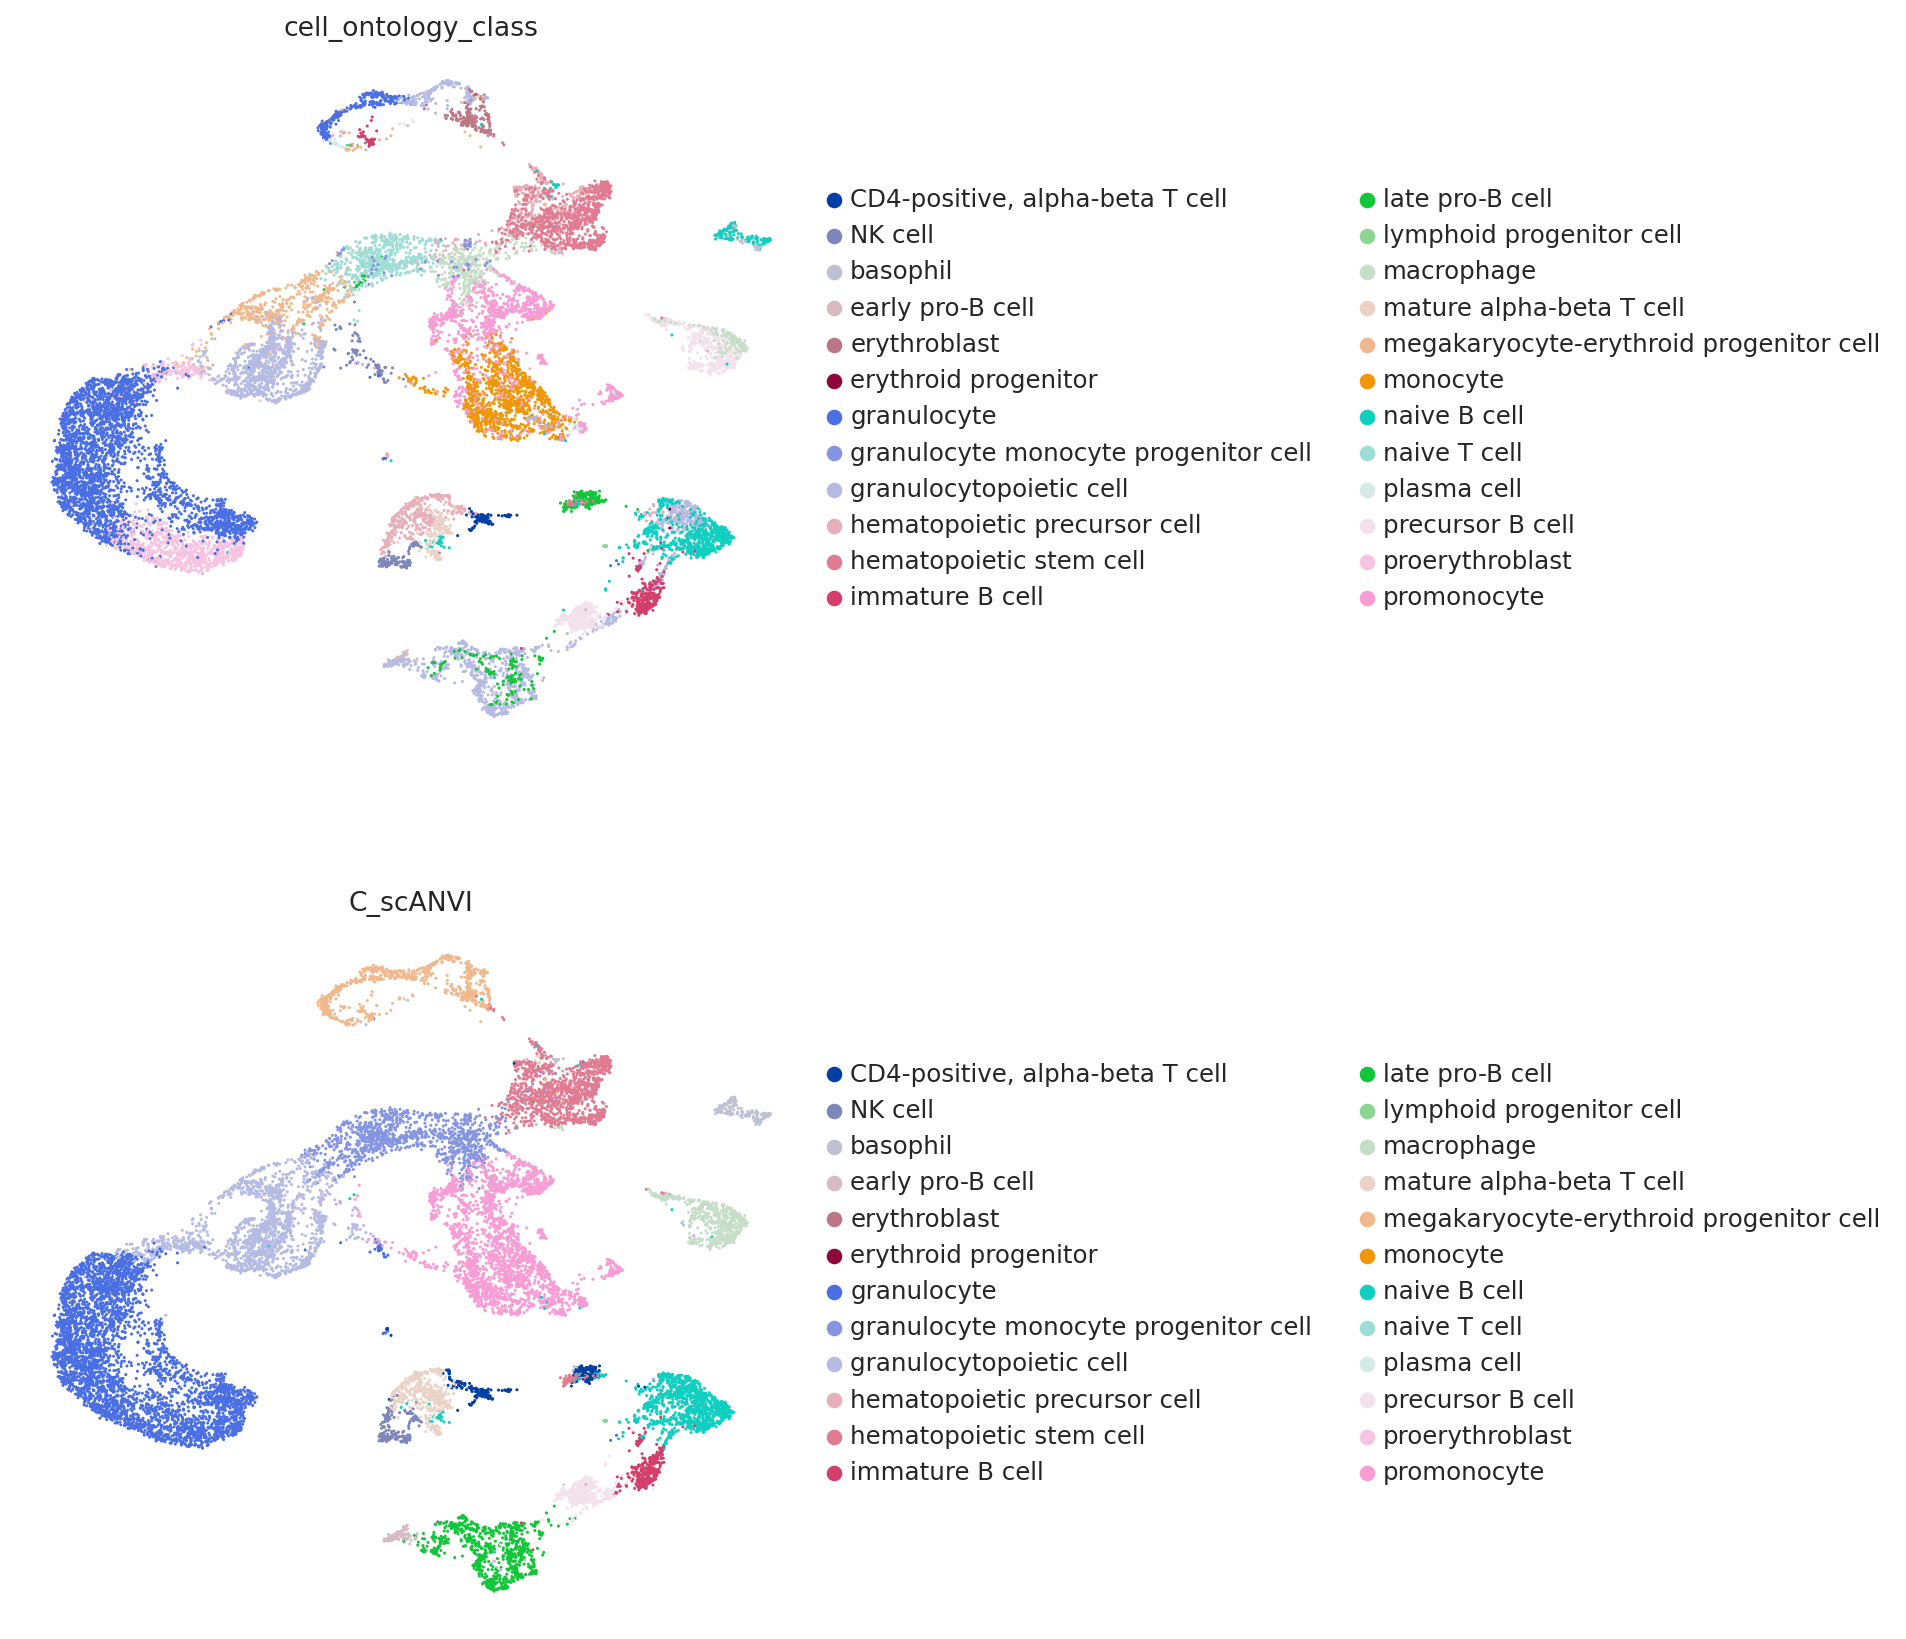

In [30]:
sc.pl.umap(
    adata,
    color=["cell_ontology_class", SCANVI_PREDICTION_KEY],
    frameon=False,
    ncols=1,
    palette=adata.uns["cell_ontology_class_colors"],
)

Now we can observe scANVI's performance using a confusion matrix.

In [31]:
df = adata.obs.groupby(["cell_ontology_class", SCANVI_PREDICTION_KEY]).size().unstack(fill_value=0)

/tmp/ipykernel_3464019/3240089291.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(["cell_ontology_class", SCANVI_PREDICTION_KEY]).size().unstack(fill_value=0)


In [32]:
conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

Text(0, 0.5, 'Observed')

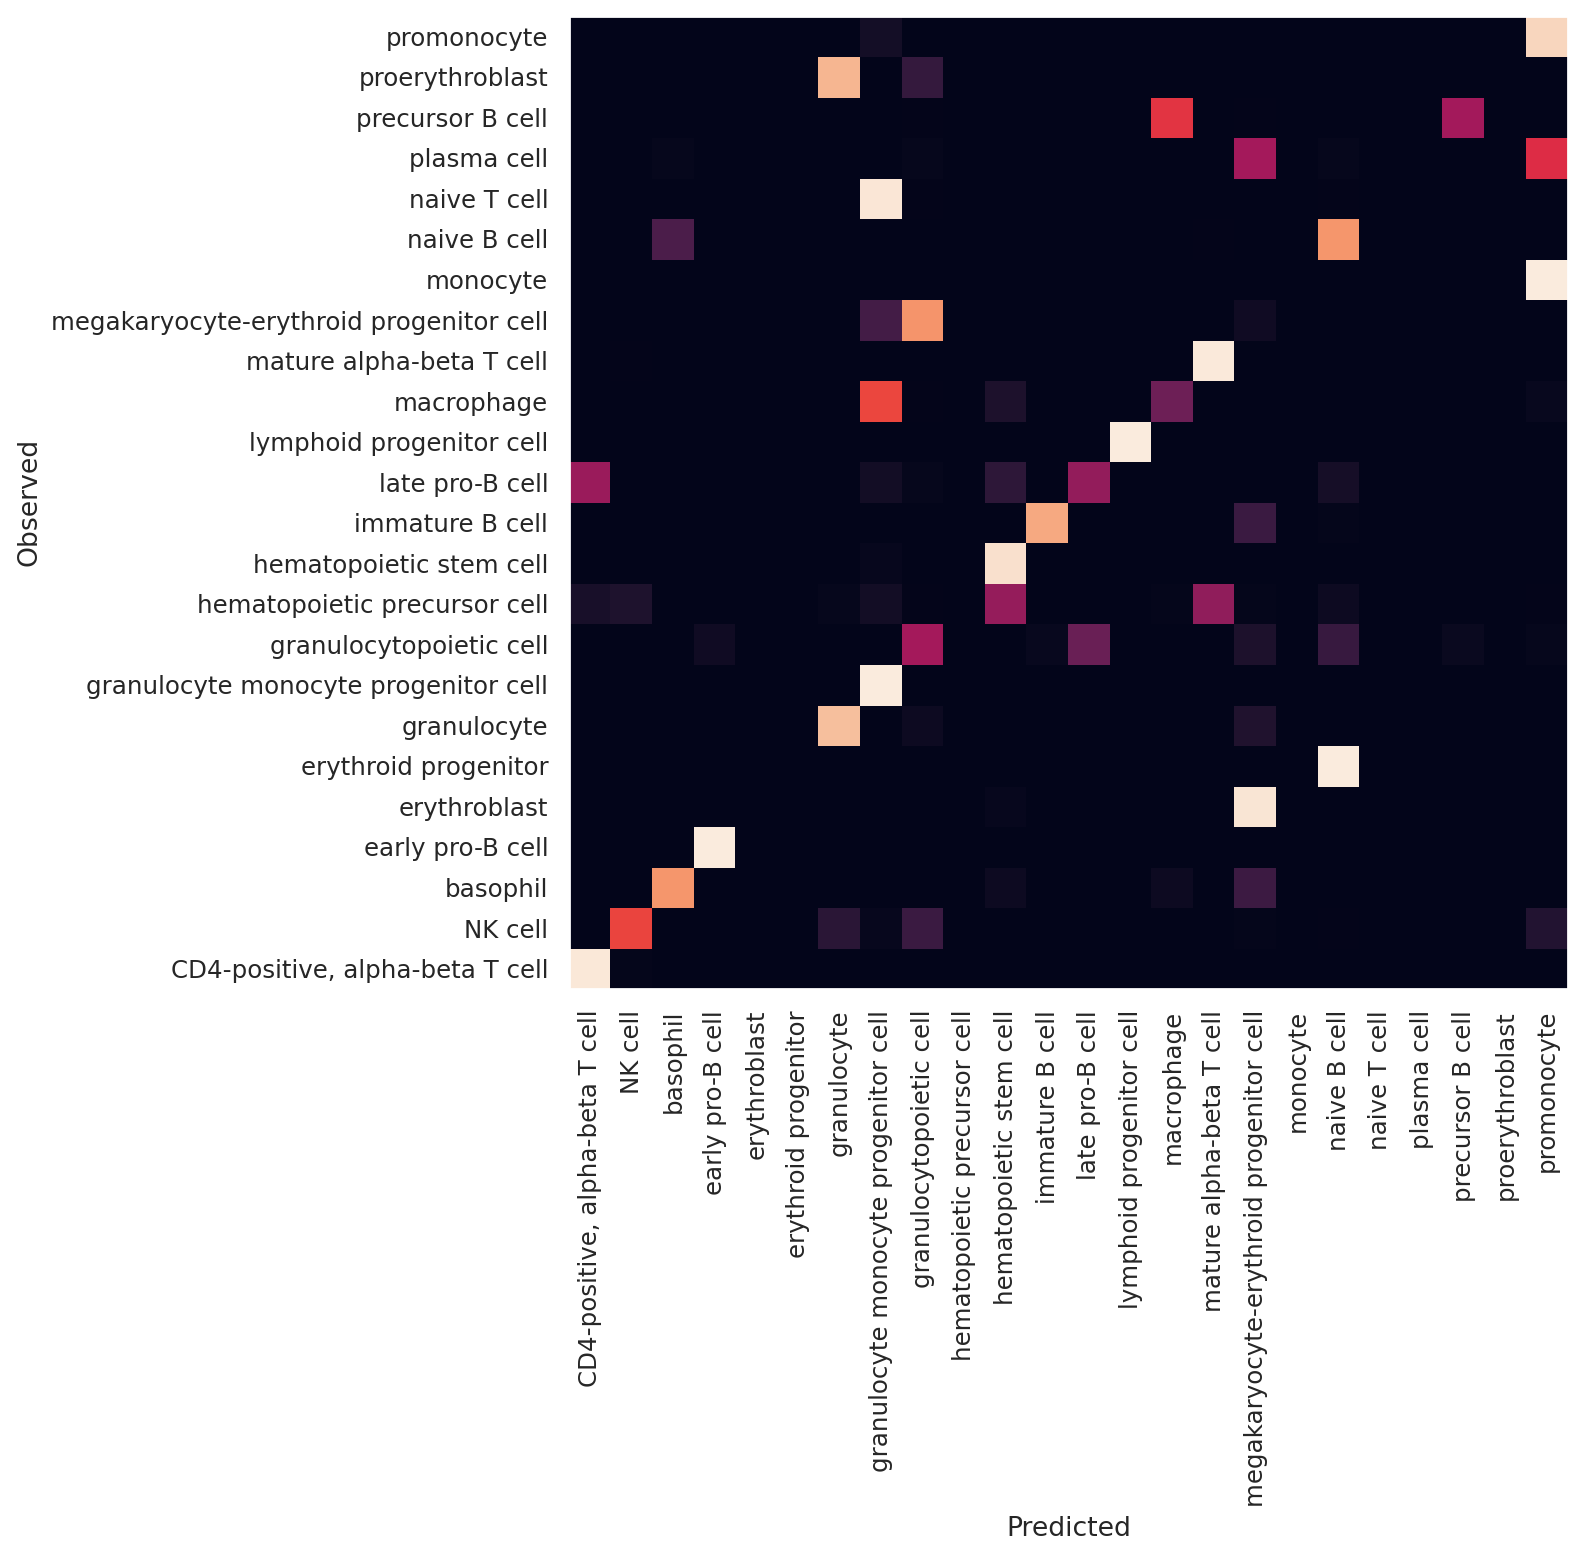

In [33]:
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

As we see in this, scANVI's latent space separates all cell types and performs well at classifying major cell types. Since the 10X data is labelled at lower resolution, the transferred labels are not always identical with the original label. However, biologically, the transferred labels are subsets of the original labels.